# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI model learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard version of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/usr/local/lib/python3.12/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import matplotlib.pyplot as plt
import scanpy as sc
import scvi
import seaborn as sns
import torch

/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:388: SyntaxWarning: invalid escape sequence '\m'
  """ Implements modularity. This quality function is well-defined only for positive edge weights.
/usr/local/lib/python3.12/site-packages/leidenalg/VertexPartition.py:761: SyntaxWarning: invalid escape sequence '\m'
  """ Implements Reichardt and Bornholdt's Potts model with a configuration null model.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:7: SyntaxWarning: invalid escape sequence '\g'
  """ Class for doing community detection using the Leiden algorithm.
/usr/local/lib/python3.12/site-packages/leidenalg/Optimiser.py:305: SyntaxWarning: invalid escape sequence '\s'
  """ Optimise the given partitions simultaneously.


/usr/local/lib/python3.12/site-packages/pyro/ops/stats.py:514: SyntaxWarning: invalid escape sequence '\g'
  """


In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.1.6


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Initialization

Load data and select the top 1000 variable genes with seurat_v3 method

In [5]:
adata_path = os.path.join(save_dir.name, "pbmc_10k_protein_v3.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
)

adata

  0%|          | 0.00/23.8M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 6855 × 16727
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells', 'highly_variable', 'encode', 'hvg_encode'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [6]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [7]:
scvi.model.LinearSCVI.setup_anndata(adata, layer="counts")
model = scvi.model.LinearSCVI(adata, n_latent=10)

In [8]:
model.train(max_epochs=250, plan_kwargs={"lr": 5e-3}, check_val_every_n_epoch=10)

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Training:   0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


`Trainer.fit` stopped: `max_epochs=250` reached.


Inspecting the convergence

<Axes: xlabel='epoch'>

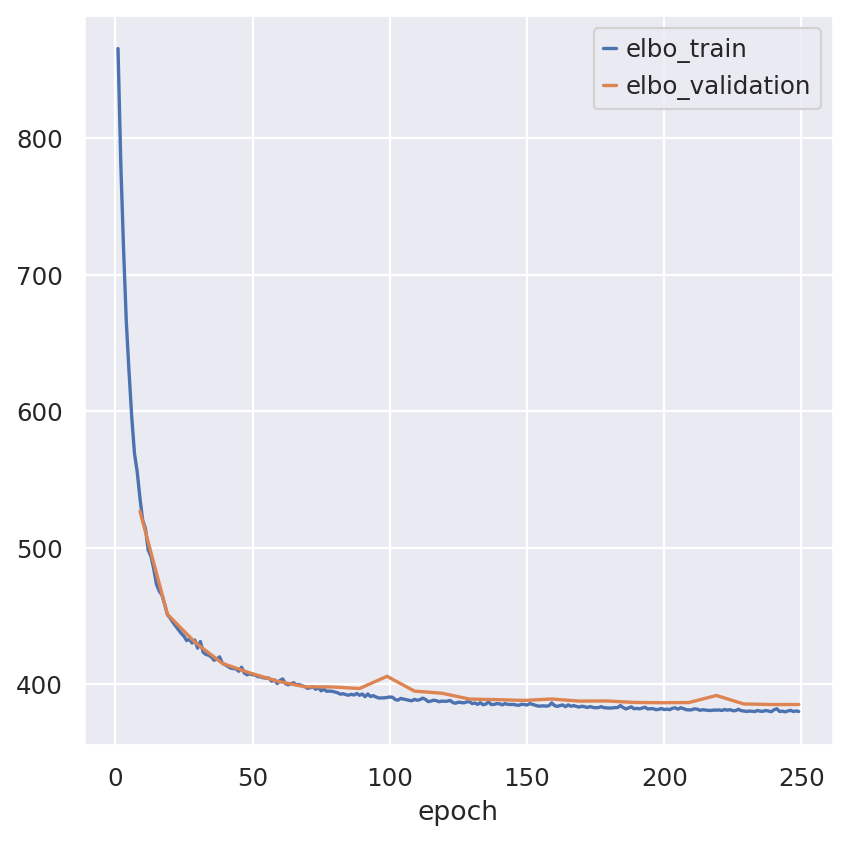

In [9]:
train_elbo = model.history["elbo_train"][1:]
test_elbo = model.history["elbo_validation"]

ax = train_elbo.plot()
test_elbo.plot(ax=ax)

## Extract and plot latent dimensions for cells

From the fitted model we extract the (mean) values for the latent dimensions. We store the values in the AnnData object for convenience.

In [10]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f"Z_{i}"] = z

Now we can plot the latent dimension coordinates for each cell. A quick (albeit not complete) way to view these is to make a series of 2D scatter plots that cover all the dimensions. Since we are representing the cells by 10 dimensions, this leads to 5 scatter plots.

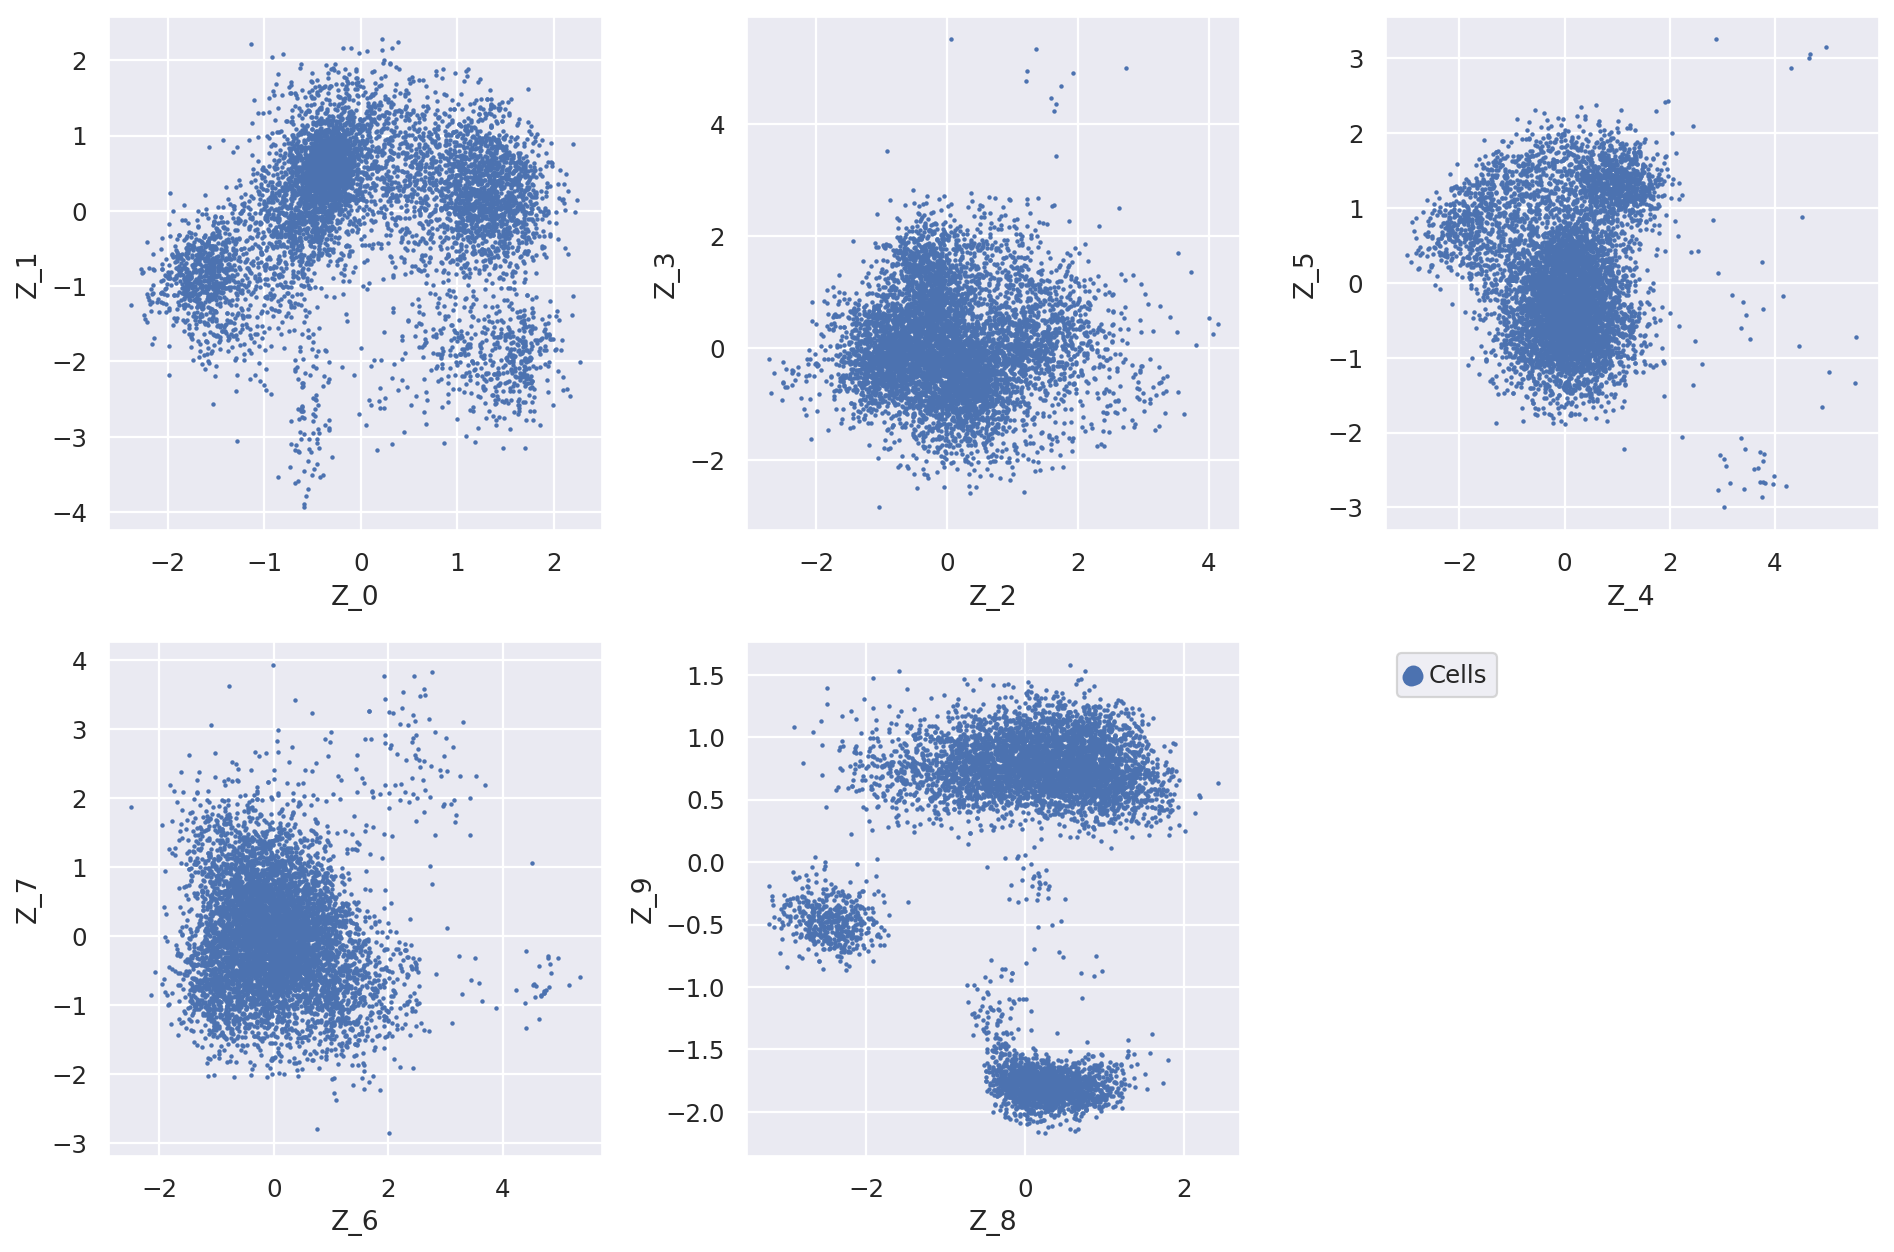

In [11]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", s=4, label="Cells")

    plt.xlabel(f"Z_{f}")
    plt.ylabel(f"Z_{f + 1}")

plt.subplot(2, 3, 6)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], marker=".", label="Cells", s=4)
plt.scatter(adata.obs[f"Z_{f}"], adata.obs[f"Z_{f + 1}"], c="w", label=None)
plt.gca().set_frame_on(False)
plt.gca().axis("off")

lgd = plt.legend(scatterpoints=3, loc="upper left")
for handle in lgd.legend_handles:
    handle.set_sizes([200])


plt.tight_layout()

The question now is how does the latent dimensions link to genes?

For a given cell x, the expression of the gene g is proportional to x_g = w\_(1, g) * z_1 + ... + w\_(10, g) * z_10. Moving from low values to high values in z_1 will mostly affect expression of genes with large w\_(1, :) weights. We can extract these weights from the `LDVAE` model, and identify which genes have high weights for each latent dimension.

In [12]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
index,,,,,,,,,,
AL645608.8,0.200178,-0.115867,0.617571,-0.009583,-0.155264,-0.391064,-0.477020,-0.502188,0.481667,0.110350
HES4,0.441254,-0.346717,0.557817,-0.514260,-0.248097,-0.048444,-0.236713,-0.237332,0.542968,-0.124358
ISG15,0.162324,0.277531,0.397635,-0.344419,0.044600,-0.162232,-0.148004,-0.096545,0.114653,0.730228
TNFRSF18,-0.581180,0.523288,1.017630,-0.471728,-0.093000,-0.018261,0.796013,-0.410670,-0.184304,2.131144
TNFRSF4,-0.156963,0.831408,0.940235,-0.572336,-0.051357,-0.391691,0.431125,-0.126451,-0.068293,2.063759


For every latent variable Z, we extract the genes with largest _magnitude_, and separate genes with large negative values from genes with large positive values. We print out the top 5 genes in each direction for each latent variable.

In [13]:
print(
    "Top loadings by magnitude\n------------------------------------------------------------------"
    "---------------------"
)
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ":\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.head(5).index])
    fstr += "\n\t...\n\t"
    fstr += "\t".join([f"{i}, {loading_[i]:.2}" for i in loading_.tail(5).index])
    print(
        fstr
        + "\n-------------------------------------------------------------------------------------"
        "--\n"
    )

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	PTGDS, -1.0	GNLY, -1.0	CES1, -1.0	LMNA, -0.96	TYROBP, -0.83
	...
	LMO7-AS1, 1.8	IGHD, 1.8	CD8B, 1.9	CCR7, 1.9	LRRN3, 2.0
---------------------------------------------------------------------------------------

Z_1:	IGLL5, -0.89	LYPD2, -0.73	MEG3, -0.7	PLD4, -0.69	AL139020.1, -0.66
	...
	CLU, 1.4	PMCH, 1.4	EMP1, 1.4	LMNA, 1.6	ZNF683, 1.9
---------------------------------------------------------------------------------------

Z_2:	LINC02446, -1.0	CD160, -1.0	HBA1, -1.0	LCNL1, -0.93	CLIC3, -0.89
	...
	COL5A3, 1.2	FOXP3, 1.2	CTLA4, 1.2	DUSP4, 1.4	IFI27, 1.6
---------------------------------------------------------------------------------------

Z_3:	C1QA, -1.8	FPR3, -1.7	C1QB, -1.6	TRDC, -1.6	GFRA2, -1.5
	...
	IGHG1, 0.81	SERPINB2, 0.83	COCH, 0.9	IGLV1-51, 0.93	IGLV6-57, 1.0
---------------------------------------------------------------------------------------

Z_4:	EGR3,

It is important to keep in mind that unlike traditional PCA, these latent variables are not ordered. Z_0 does not necessarily explain more variance than Z_1.

These top genes can be interpreted as following most of the structural variation in the data.

The `LinearSCVI` model further supports the same scVI functionality as the `SCVI` model, so all posterior methods work the same. Here we show how to use scanpy to visualize the latent space.

In [14]:
SCVI_LATENT_KEY = "X_scVI"
SCVI_CLUSTERS_KEY = "leiden_scVI"

adata.obsm[SCVI_LATENT_KEY] = Z_hat
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.8)

/tmp/ipykernel_154/2258835019.py:7: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.8)


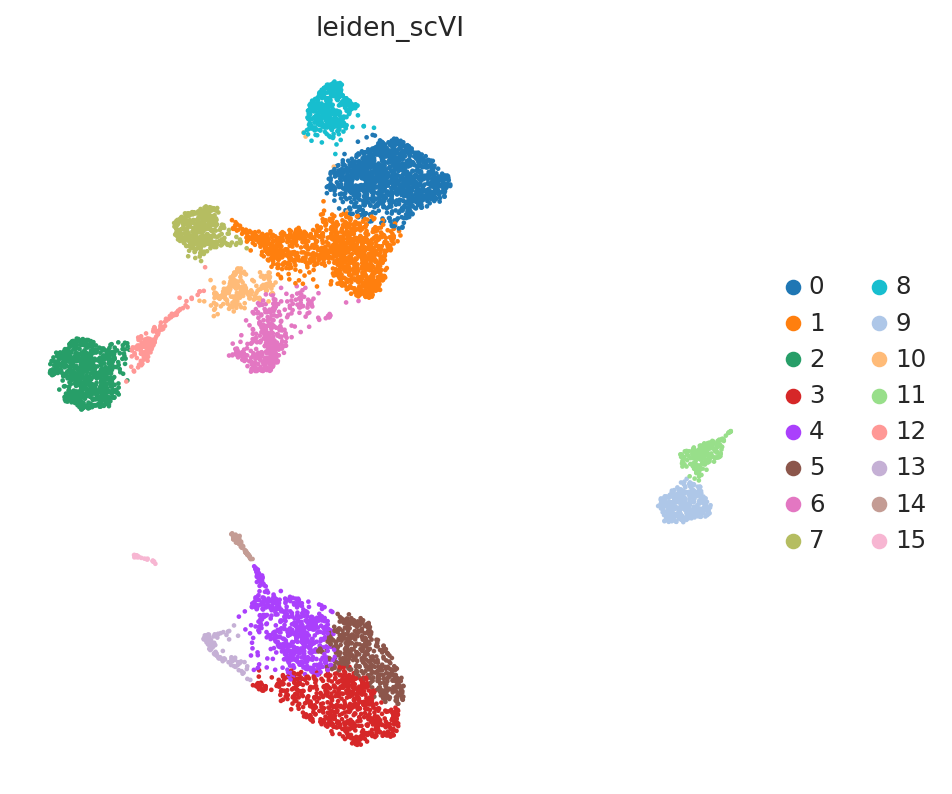

In [15]:
sc.pl.umap(adata, color=[SCVI_CLUSTERS_KEY])

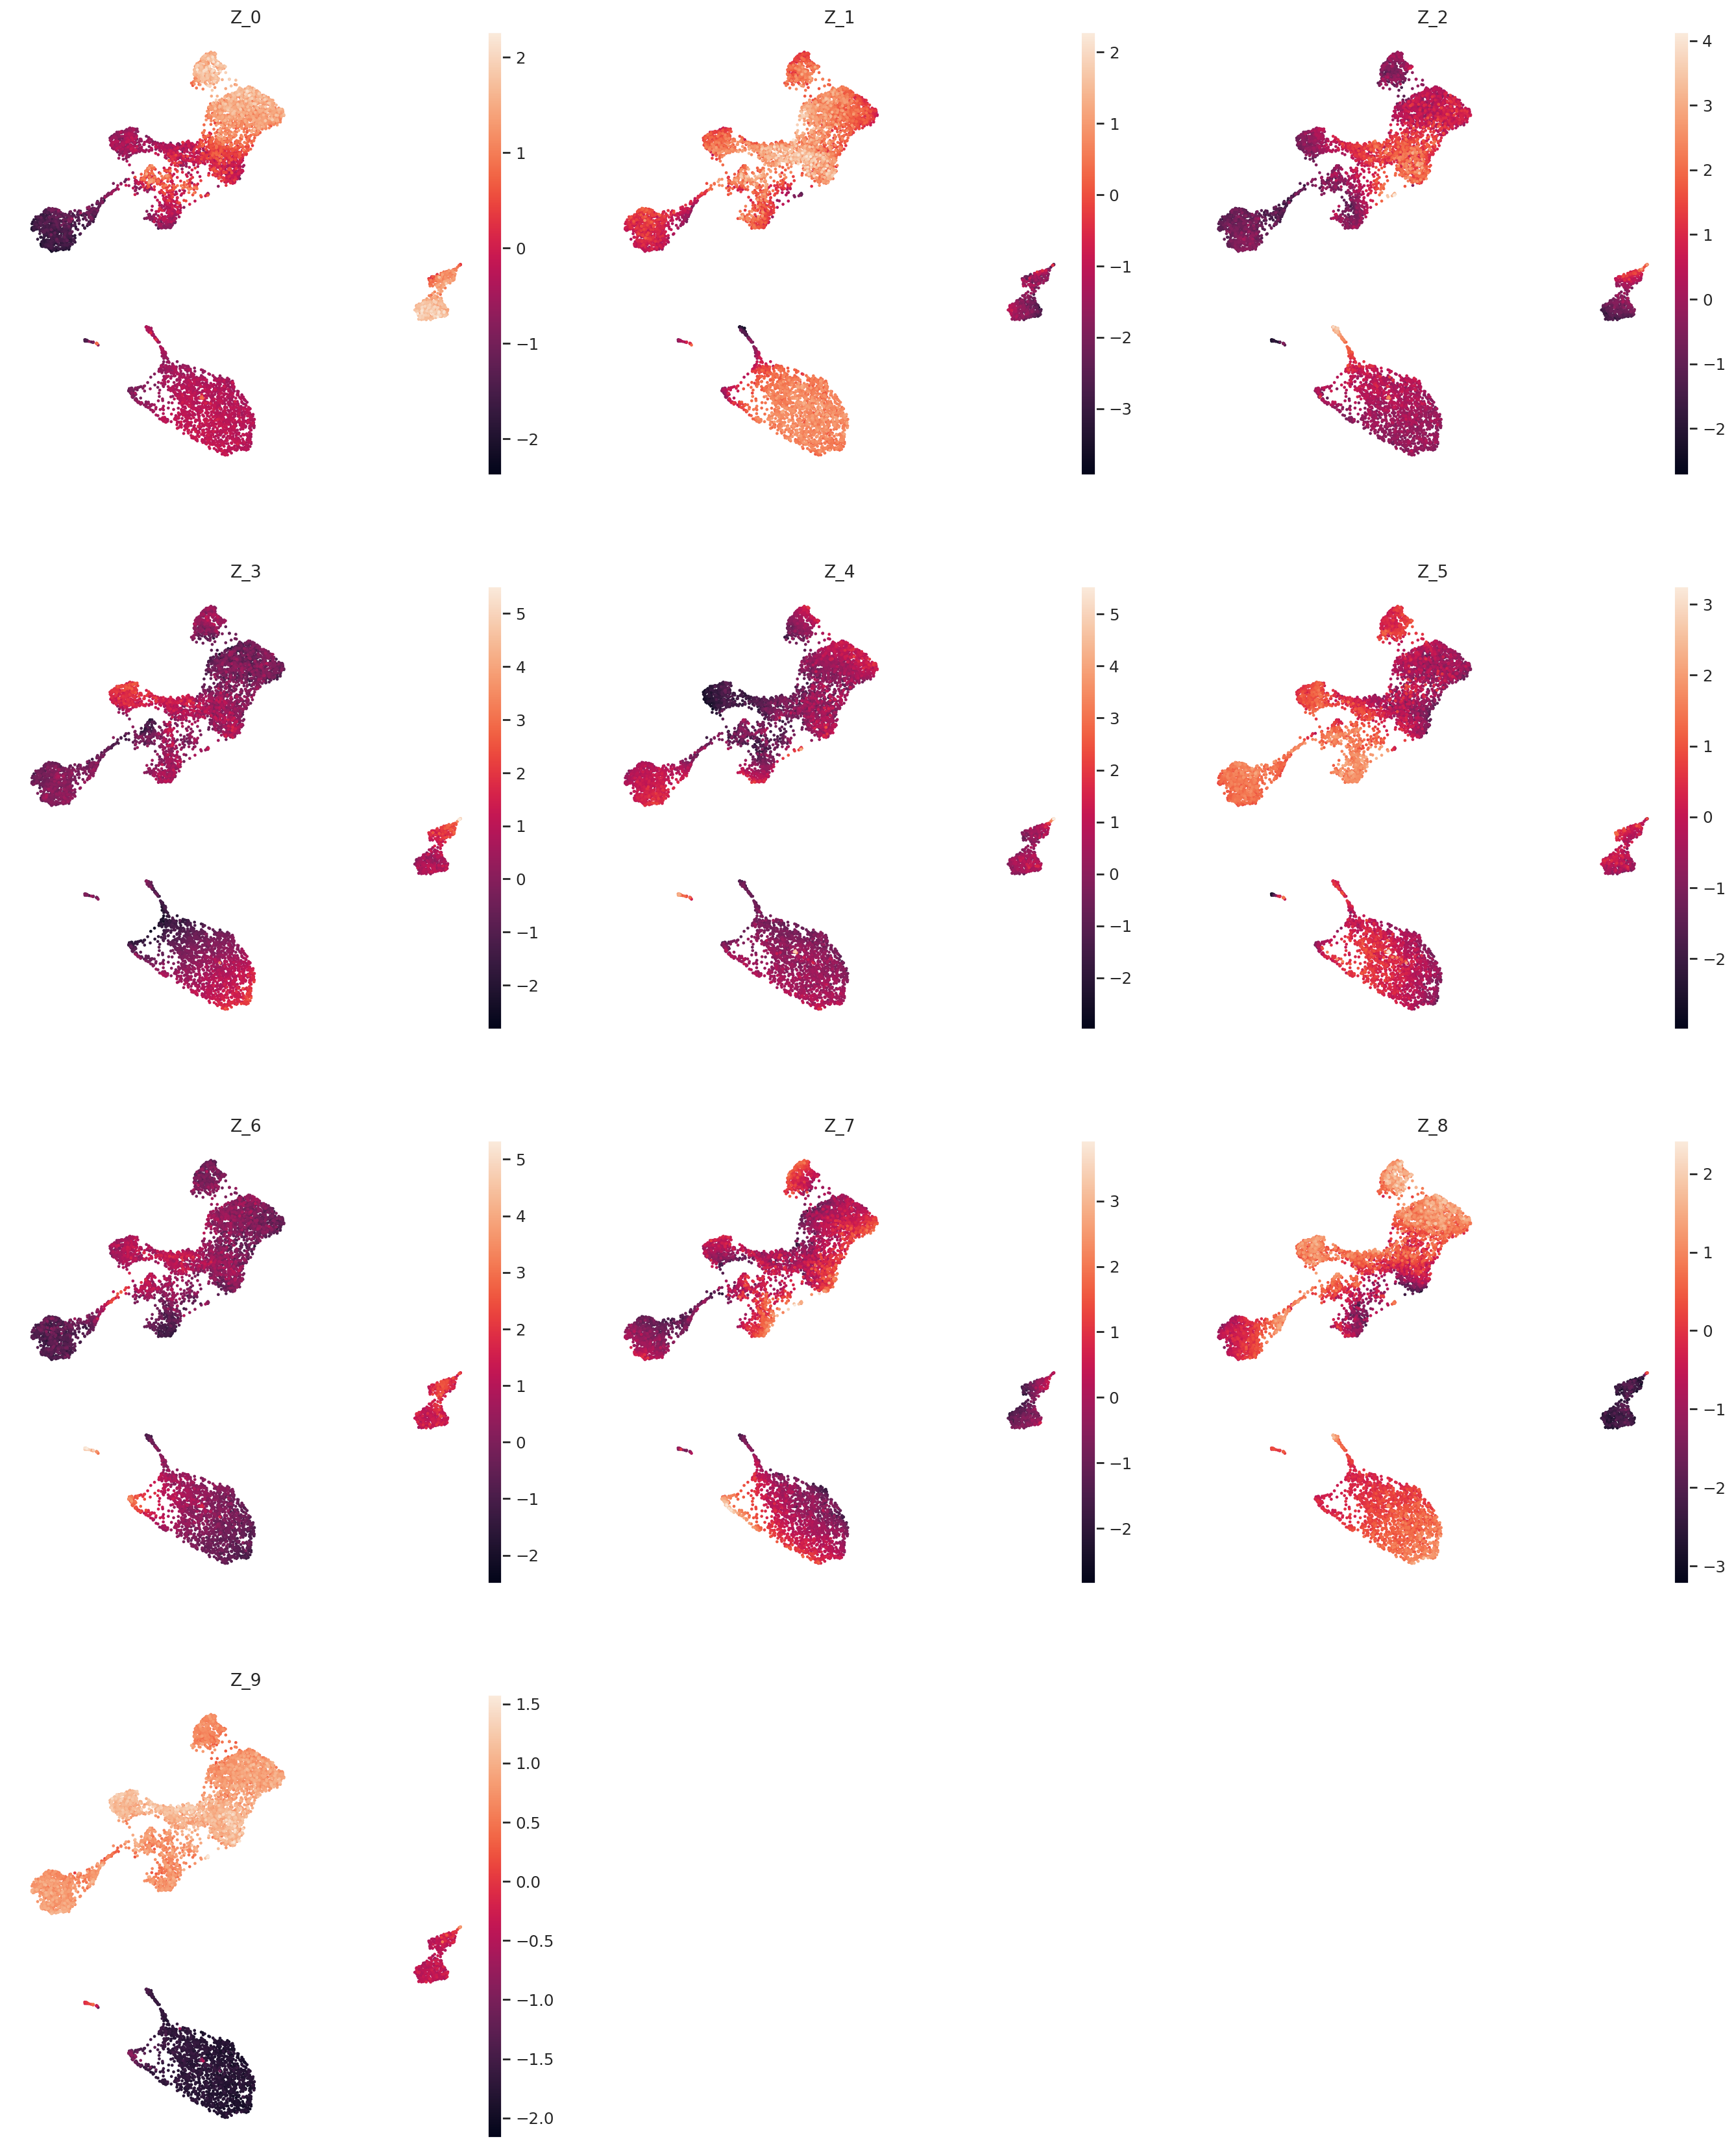

In [16]:
zs = [f"Z_{i}" for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)